In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('CarPrice_Assignment.csv')

In [3]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


**There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'. For example, Chevrolet impala has 'Chevrolet' as the car company name and 'impala' as the car model name. we need to consider only the company name as the independent variable for model building.**

In [4]:
# Extract car name from the columns
df['CarName'] = df['CarName'].apply(lambda X:X.split(' ')[0])

In [5]:
# Checking for unique items in car name
df['CarName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [6]:
# there is a duplicate item Nissan due to the upper case letter. let's keep all items in lower case
df['CarName'] = df['CarName'].str.lower()

# As we noticed some duplicate items in car name, we have to fix those items
df['CarName'] = df['CarName'].str.replace('maxda', 'mazda')
df['CarName'] = df['CarName'].str.replace('porcshce', 'porsche')
df['CarName'] = df['CarName'].str.replace('toyouta', 'toyota')
df['CarName'] = df['CarName'].str.replace('vokswagen', 'volkswagen')
df['CarName'] = df['CarName'].str.replace('vw', 'volkswagen')
df['CarName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [7]:
df['price'].describe()

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64

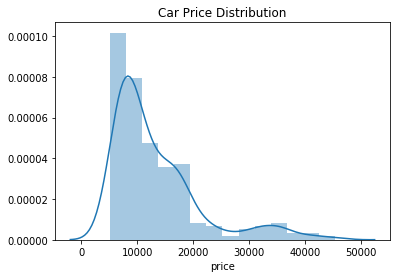

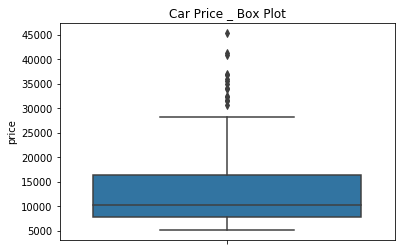

In [8]:
# Car Price distribution

sns.distplot(df['price'])
plt.title('Car Price Distribution')
plt.show()

sns.boxplot(y = df['price'])
plt.title('Car Price _ Box Plot')
plt.show()

* Dataset having more low car prices. from the above plot, we can see that the majority of distribution (75%) below 18000 approximately and only 20 - 25% left between 18000 and 45000
* price distribution right-skewed

In [9]:
# Numerical columns list
Num_columns_list = df.select_dtypes(exclude = ['object','category']).columns
Num_columns_list

Index(['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

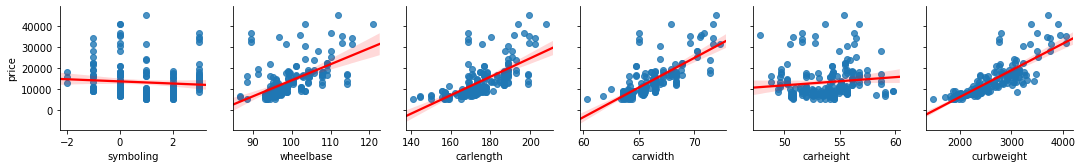

In [10]:
# Pairplot of all numerical variables with respect to price
sns.pairplot(data = df, x_vars= ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight','curbweight'], 
             y_vars = 'price', kind = 'reg',plot_kws={'line_kws':{'color':'red'}})
plt.show()

* `wheelbase`,`carlength`,`carwidth` and `curbweight` are highly correlated positively with price
* `carheight` look not much significant with price
* `symboling` considered as categorical variables

In [11]:
#symboling assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.
symboling_dict = {3:'risk_rating_3',2:'risk_rating_2',1:'risk_rating_1',0:'risk_rating_0',-1:'safe_rating_1',-2:'safe_rating_2'}

In [12]:
df['symboling'] = df['symboling'].apply(lambda X : symboling_dict[X])

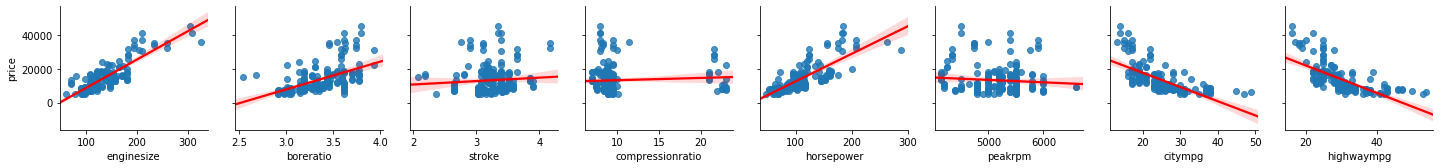

In [13]:
# Pairplot of all numerical variables with respect to price
sns.pairplot(data = df, x_vars= ['enginesize', 'boreratio', 'stroke', 'compressionratio','horsepower', 'peakrpm','citympg',
                                     'highwaympg',],y_vars = 'price', kind = 'reg',plot_kws={'line_kws':{'color':'red'}})
plt.show()

* `enginesize`,`boreratio` and `horsepower` are highly correlated positively with price
* `citympg` and `highwaympg` are negatively correlated with price
* `compressionratio`,`stroke` and `peakrpm` :  looks not much significant with price

In [14]:
# create new columns named as 'avg fuel economy' derived from city fuel economy and highway fuel economy
df['avg_fuel_economy'] = df['citympg']*0.5 + df['highwaympg']*0.5

In [15]:
# Numerical columns list
Num_columns_list = df.select_dtypes(exclude = ['object','category']).columns
Num_columns_list

Index(['car_ID', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price',
       'avg_fuel_economy'],
      dtype='object')

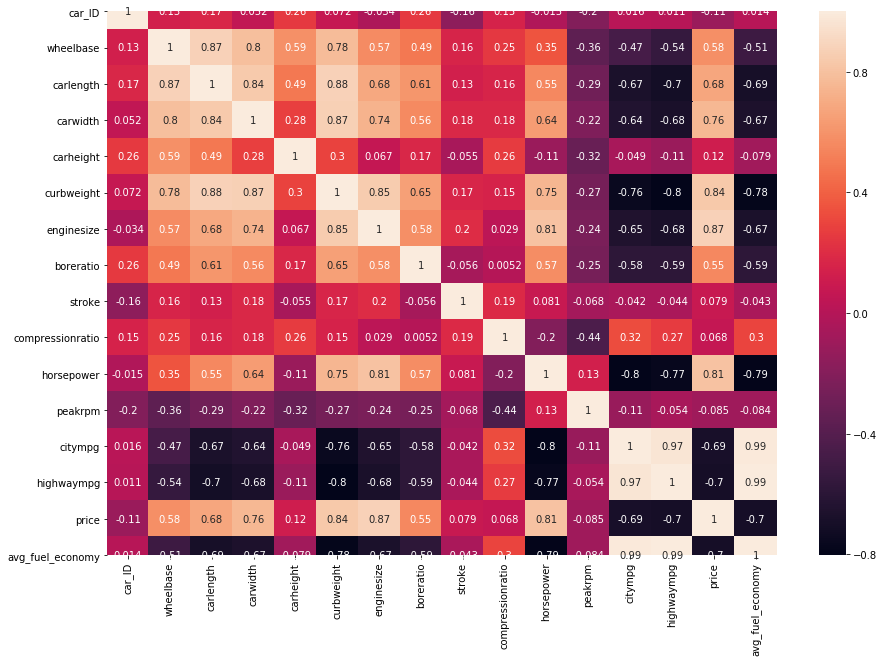

In [16]:
plt.figure(figsize = (15,10))
sns.heatmap(df[Num_columns_list].corr(), annot = True)
plt.show()

* `wheelbase` highly correlated with `carlength`, `carwidth` & `curbweight`
* `enginesize` has reasonable correlation with `horsepower`, `carlength`, `carwidth` & `curbweight`

In [17]:
# Categorical columns list
Cat_columns_list = df.select_dtypes(include = ['object','category']).columns
Cat_columns_list

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem'],
      dtype='object')

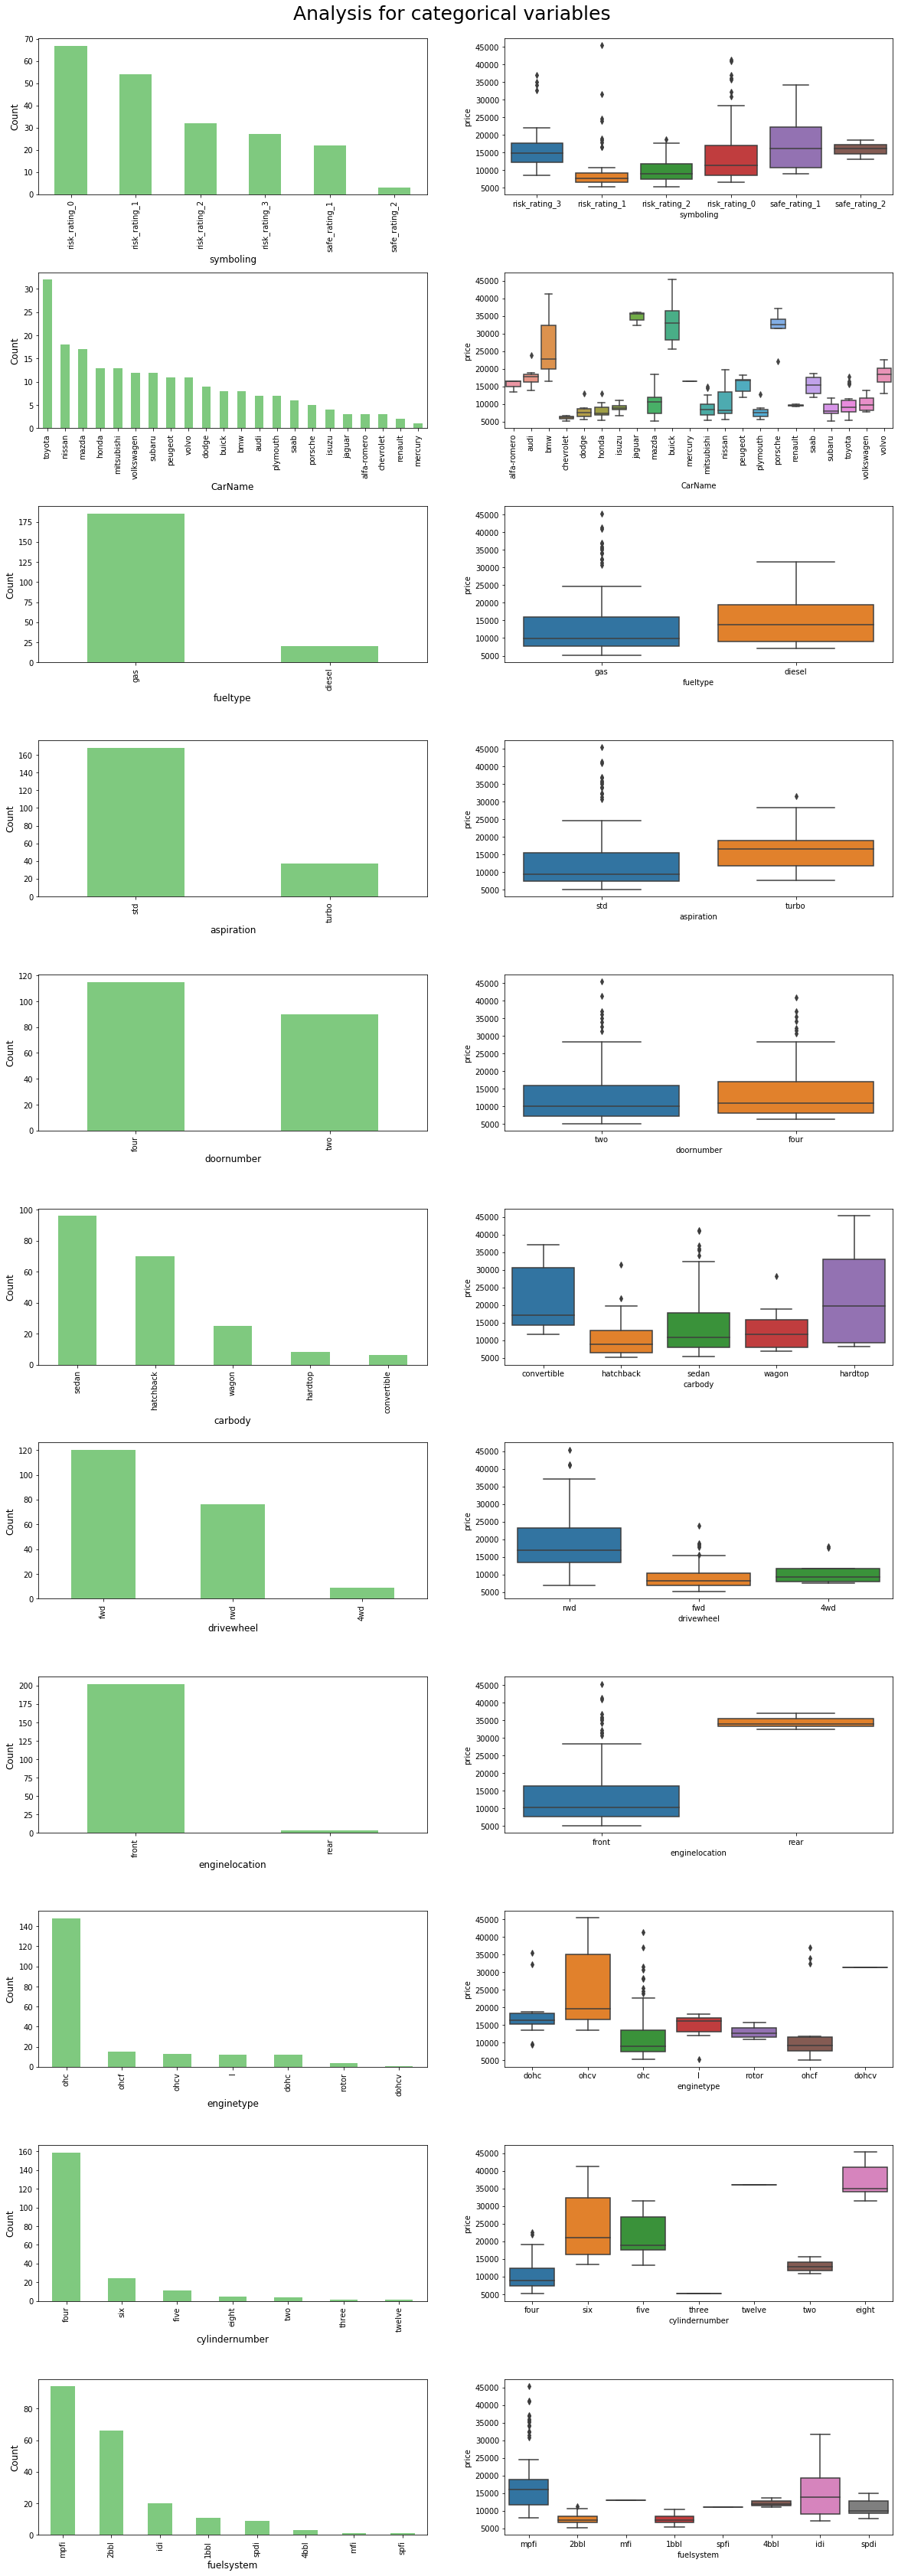

In [18]:
fig, axes = plt.subplots(11,2, figsize= (20,60))
count = 0
for i in Cat_columns_list:
    ax = axes[count//2, count%2]
    df[i].value_counts().plot(kind='bar', ax = ax, colormap='Accent')
    ax.set_xlabel(i, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    count+=1
    ax = axes[count//2, count%2]
    sns.boxplot(y = 'price', data = df, ax = ax, x= i)
    if i == 'CarName':
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    count+=1
fig.suptitle('Analysis for categorical variables',fontsize=25,x =0.5, y=0.89)
fig.subplots_adjust(wspace=0.2,hspace=0.5 ) # adjust spaces between subplots width and height  

* `symboling` rating 0 & 1 most frequent cars  & safe rating 1 is high price, which means safer car expensive. but safe rating 2 price is approximately the same as risk rating 3.
* `CarName` Toyota cars more in the dataset. might be most of the people like to buy Toyota. Expensive cars are very less in count in the dataset. jaguar, brick & Porsche cares are having the highest average prices.
* `fueltype` gas fueled cars are the most frequent and the price of gas-fueled cars are less expensive than diesel cars.
* `aspiration` with std is more frequent then turbo & turbo cars are expensive than std cars.
* `doornumber` four-door numbers are most frequent than two but price ranges for both of them approximately same.
* `carbody` sedan cars are more frequent and hardtop & convertible cars are the most expensive.
* `drivewheel` most frequent cars with fwd, but most expensive cars are rwd
* `enginelocation` almost all cars with front enginelocation, very few with rare enginelocation
* `enginetype` ohc engine types are most frequent with less expensive cars & ohcv engine cars are expensive.
* `cylindernumber` most frequent cars with four cylinders eight-cylinder cars are expensive.
* `fuelsystem` mpfi and 2bbl are most frequent. mpfi and idi are the most expensive.

In [19]:
# check the median prices with respect to car company names and create a dictionary
CarName_Median_Price_dict = df.groupby(by='CarName').median()['price'].sort_values(ascending = False).to_dict()

# create series with median car name prices of respective car company names
CarName_Median_Price = df['CarName'].apply(lambda X:CarName_Median_Price_dict[X])

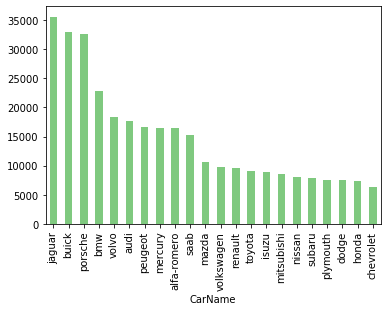

In [20]:
# plot median prices with car company names
df.groupby(by='CarName').median()['price'].sort_values(ascending = False).plot('bar',colormap='Accent') 
plt.show()

In [21]:
Low_price_Cars = []
Median_price_Cars = []
High_price_Cars = []
for k,v in CarName_Median_Price_dict.items():
    if v <=10000:
        Low_price_Cars.append(k)
    elif v <= 20000:
        Median_price_Cars.append(k)
    else:
        High_price_Cars.append(k)
print(Low_price_Cars)
print(Median_price_Cars)
print(High_price_Cars)

['volkswagen', 'renault', 'toyota', 'isuzu', 'mitsubishi', 'nissan', 'subaru', 'plymouth', 'dodge', 'honda', 'chevrolet']
['volvo', 'audi', 'peugeot', 'mercury', 'alfa-romero', 'saab', 'mazda']
['jaguar', 'buick', 'porsche', 'bmw']


In [22]:
# Create Car compnay groups with respect to price ranges, Low Median, High
df['CarName_Grp_PriceRange']  = pd.cut(CarName_Median_Price.values, bins = [0,10000,20000,50000],
                                       labels = ['Low_price_Carbrands', 'Median_price_Carbrands', 'High_price_Carbrands'])

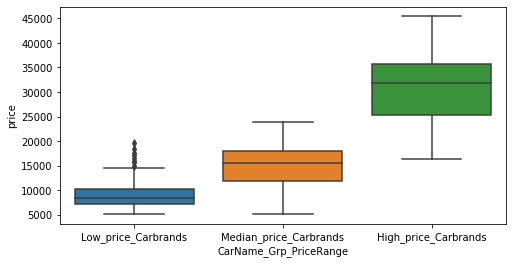

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x = df['CarName_Grp_PriceRange'], y = df['price'])
plt.show()

### List of significant variables based on visual analysis :

* CarName_Grp_PriceRange 
* fueltype
* aspiration
* carbody
* drivewheel
* enginetype
* cylindernumber
* fuelsystem
* wheelbase
* carlength
* carwidth
* curbweight
* enginesize
* boreratio
* horsepower
* avg_fuel_economy

In [24]:
# list of significant variables
df_fil = df[['CarName_Grp_PriceRange','fueltype','aspiration','carbody','drivewheel','enginetype','cylindernumber','fuelsystem',
             'wheelbase','carlength','carwidth','curbweight','enginesize','boreratio','horsepower','avg_fuel_economy','price']]

In [25]:
df_fil.head()

,CarName_Grp_PriceRange,fueltype,aspiration,carbody,drivewheel,enginetype,cylindernumber,fuelsystem,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,avg_fuel_economy,price
0,Median_price_Carbrands,gas,std,convertible,rwd,dohc,four,mpfi,88.6,168.8,64.1,2548,130,3.47,111,24.0,13495.0
1,Median_price_Carbrands,gas,std,convertible,rwd,dohc,four,mpfi,88.6,168.8,64.1,2548,130,3.47,111,24.0,16500.0
2,Median_price_Carbrands,gas,std,hatchback,rwd,ohcv,six,mpfi,94.5,171.2,65.5,2823,152,2.68,154,22.5,16500.0
3,Median_price_Carbrands,gas,std,sedan,fwd,ohc,four,mpfi,99.8,176.6,66.2,2337,109,3.19,102,27.0,13950.0
4,Median_price_Carbrands,gas,std,sedan,4wd,ohc,five,mpfi,99.4,176.6,66.4,2824,136,3.19,115,20.0,17450.0


In [26]:
# Categorical columns list
Cat_columns_list = df_fil.select_dtypes(include = ['object','category']).columns
Cat_columns_list

Index(['CarName_Grp_PriceRange', 'fueltype', 'aspiration', 'carbody',
       'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem'],
      dtype='object')

In [27]:
# before creating dummy variables, add column name to its respective items, except for 'CarName_Grp_PriceRange' column 
#so that it will be easy to understand variable after creating dummies

for i in Cat_columns_list[1:]:
    df_fil[i] = df_fil[i].apply(lambda X : i+'_'+X)

In [28]:
# Create dummy variables for all category variables
for i in Cat_columns_list:
    temp_df = pd.get_dummies(df_fil[i], drop_first = True)
    df_fil = pd.concat([df_fil,temp_df], axis =1)  

In [29]:
# Delete all categorical variables
df_fil.drop(columns = Cat_columns_list, inplace = True)

In [30]:
# keep the dataframe values in float type
df_fil = df_fil.astype('float64')

In [31]:
# split train _ Test data sets
df_train, df_test = train_test_split(df_fil, train_size = 0.7, test_size = 0.3, random_state = 100)

In [32]:
# Train and test data frames shapes
print('train dataset shape :',df_train.shape)
print('test dataset shape :',df_test.shape)

train dataset shape : (143, 38)
test dataset shape : (62, 38)


In [33]:
# apply scaler() to train dataset columns
train_col_list = df_train.columns # list of columns from train dataset
df_train[train_col_list] = scaler.fit_transform(df_train[train_col_list])

In [34]:
df_train.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,avg_fuel_economy,price,Median_price_Carbrands,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
122,0.244828,0.426016,0.291667,0.272692,0.139623,0.230159,0.083333,0.534247,0.068818,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.272414,0.452033,0.666667,0.500388,0.339623,1.000000,0.395833,0.219178,0.466890,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
166,0.272414,0.448780,0.308333,0.314973,0.139623,0.444444,0.266667,0.342466,0.122110,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.068966,0.450407,0.316667,0.411171,0.260377,0.626984,0.262500,0.246575,0.314446,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199,0.610345,0.775610,0.575000,0.647401,0.260377,0.746032,0.475000,0.123288,0.382131,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
# Dividing train dataset into X and Y sets for the model building
y_train = df_train.pop('price')
X_train = df_train

In [36]:
lm = LinearRegression() # creating linear regression object
lm.fit(X_train, y_train)

rfe = RFE(lm, 10) # running RFE
rfe = rfe.fit(X_train, y_train)

In [37]:
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['carwidth', 'curbweight', 'horsepower', 'avg_fuel_economy',
       'High_price_Carbrands', 'carbody_hatchback', 'enginetype_dohcv',
       'enginetype_rotor', 'cylindernumber_three', 'cylindernumber_twelve'],
      dtype='object')

In [38]:
# check the correlation values of RFE selected variables with respect to price
pd.concat([df_train[rfe_col], y_train], axis = 1).corr()['price'].sort_values(ascending=False)

price                    1.000000
curbweight               0.861860
horsepower               0.806183
carwidth                 0.799380
High_price_Carbrands     0.792077
cylindernumber_twelve    0.247489
enginetype_dohcv         0.197875
enginetype_rotor        -0.000793
cylindernumber_three    -0.085274
carbody_hatchback       -0.252484
avg_fuel_economy        -0.686057
Name: price, dtype: float64

# Initial Model:

In [39]:
# Creating X_train dataset with RFE selected variables
X_train_rfe = X_train[rfe_col]

In [40]:
# adding a constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

In [41]:
lm = sm.OLS(y_train, X_train_rfe).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     166.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           1.00e-69
Time:                        20:24:30   Log-Likelihood:                 203.61
No. Observations:                 143   AIC:                            -385.2
Df Residuals:                     132   BIC:                            -352.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1837      0.041     -4.479      0.000      -0.265      -0.103
carwidth                  0.2686      0.060      4.467      0.000       0.150       0.387
curbweight                0.2307      0.067      3.443      0.001       0.098       0.363
horsepower                0.5272      0.074      7.154      0.000       0.381       0.673
avg_fuel_economy          0.1254      0.059      2.131      0.035       0.009       0.242
High_price_Carbrands      0.2678      0.020     13.388      0.000       0.228       0.307
carbody_hatchback        -0.0336      0.012     -2.747      0.007      -0.058      -0.009
enginetype_dohcv         -0.3140      0.079     -3.990      0.000      -0.470      -0.158
enginetype_rotor          0.0803      0.035      2.326      0.022       0.012       0.149
cylindernumber_three      0.0979      0.065      1.499      0.136      -0.031       0.227
cylindernumber_twelve    -0.1518      0.068     -2.226      0.028      -0.287      -0.017
==============================================================================
Omnibus:                       38.637   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.476
Skew:                           1.096   Prob(JB):                     5.03e-21
Kurtosis:                       6.299   Cond. No.                         29.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* `cylindernumber_three` high p-value. acceptable significance level is 0.05. so we can drop this variable

# Model_1:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     183.0
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           2.17e-70
Time:                        20:24:30   Log-Likelihood:                 202.41
No. Observations:                 143   AIC:                            -384.8
Df Residuals:                     133   BIC:                            -355.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.19

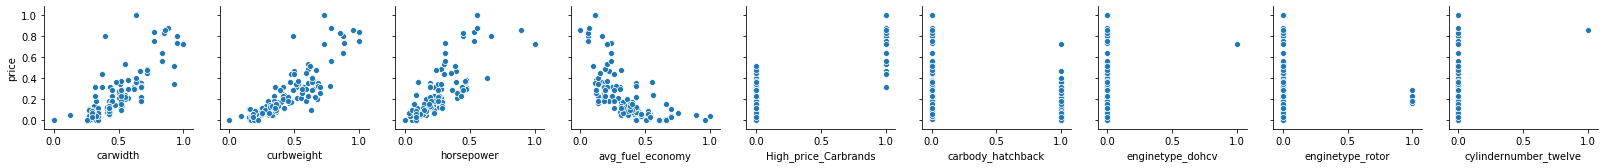

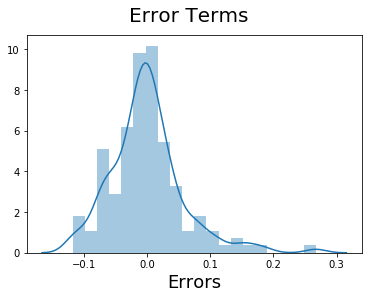

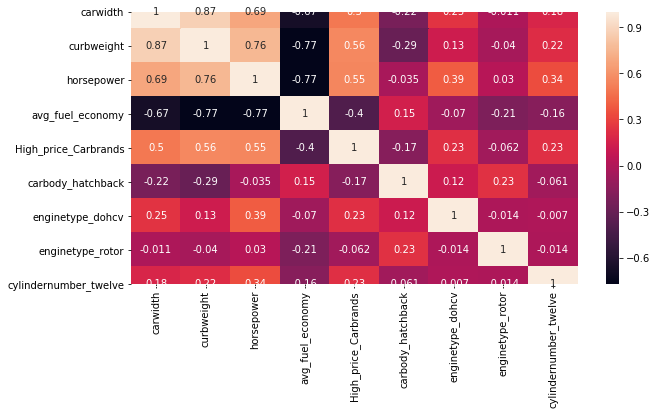

In [42]:
X_train_rfe_new = X_train_rfe.drop('cylindernumber_three', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                 
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (10,5))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* `curbweight` high VIF, we can drop this variable to avoid multicollinearity

# Model_2:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     187.1
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           8.32e-69
Time:                        20:24:34   Log-Likelihood:                 195.61
No. Observations:                 143   AIC:                            -373.2
Df Residuals:                     134   BIC:                            -346.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.16

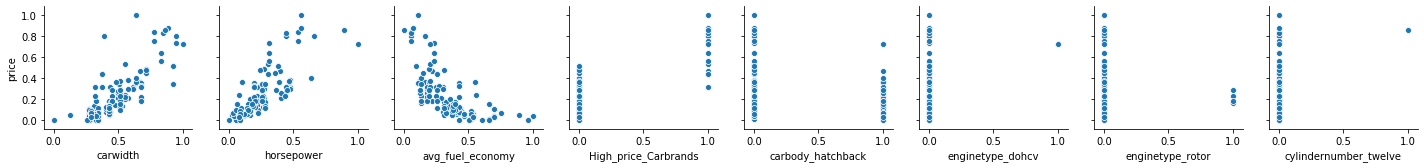

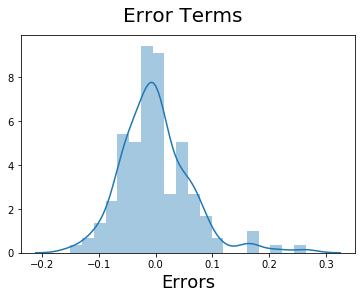

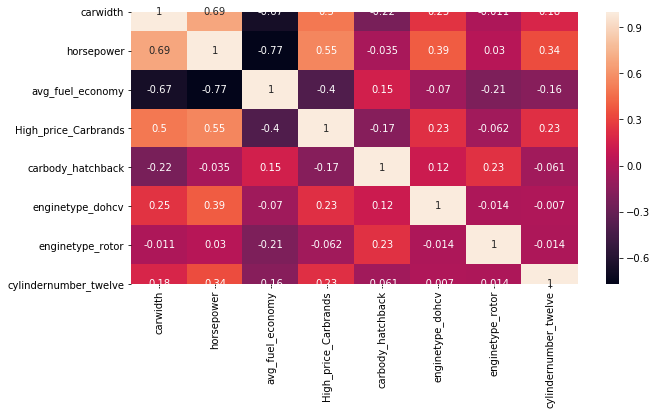

In [43]:
X_train_rfe_new = X_train_rfe_new.drop('curbweight', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (10,5))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* `avg_fuel_economy` high p-value. acceptable significance level is 0.05. so we can drop this variable

# Model_3:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     210.2
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           2.47e-69
Time:                        20:24:37   Log-Likelihood:                 194.00
No. Observations:                 143   AIC:                            -372.0
Df Residuals:                     135   BIC:                            -348.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.09

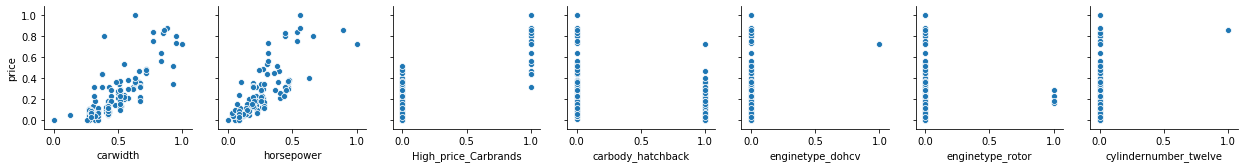

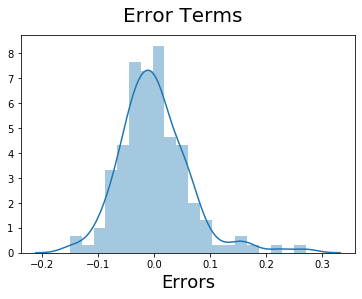

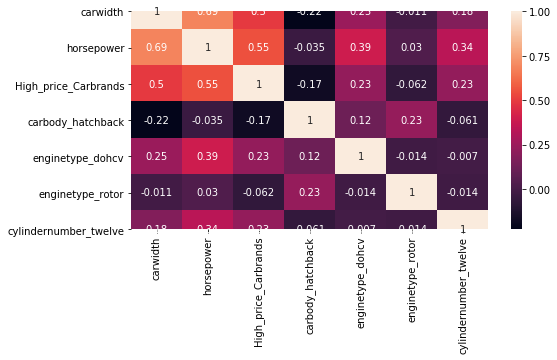

In [44]:
X_train_rfe_new = X_train_rfe_new.drop('avg_fuel_economy', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (8,4))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* `enginetype_rotor` high p-value. acceptable significance level is 0.05. so we can drop this variable

# Model_4:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     243.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           3.77e-70
Time:                        20:24:41   Log-Likelihood:                 193.04
No. Observations:                 143   AIC:                            -372.1
Df Residuals:                     136   BIC:                            -351.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.09

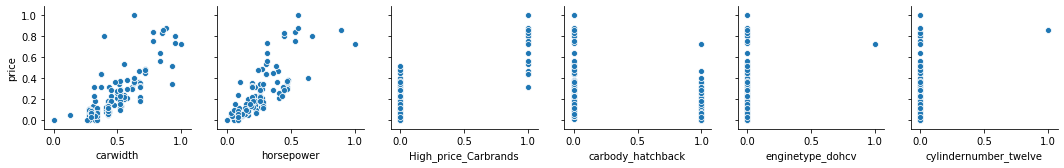

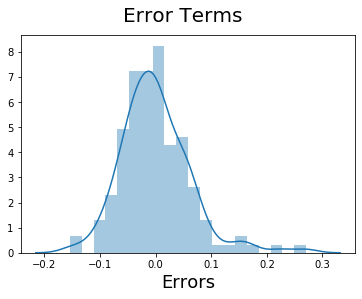

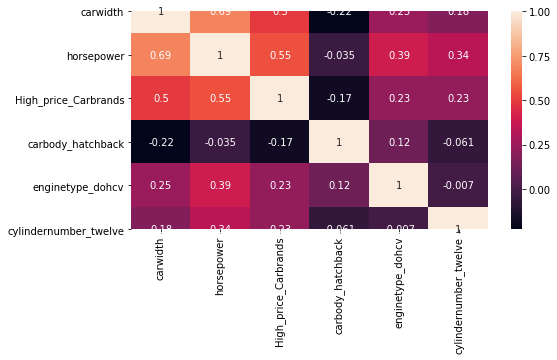

In [45]:
X_train_rfe_new = X_train_rfe_new.drop('enginetype_rotor', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (8,4))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* `cylindernumber_twelve` p-value close to the acceptable significance level is 0.05. so we can drop this variable to check the effect.

# Model_5:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     284.8
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           1.57e-70
Time:                        20:24:43   Log-Likelihood:                 190.93
No. Observations:                 143   AIC:                            -369.9
Df Residuals:                     137   BIC:                            -352.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0970 

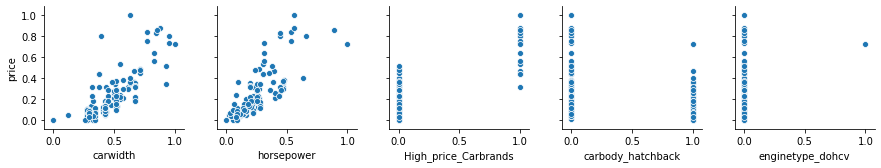

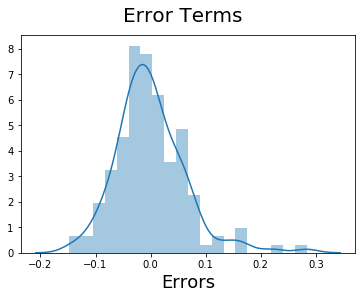

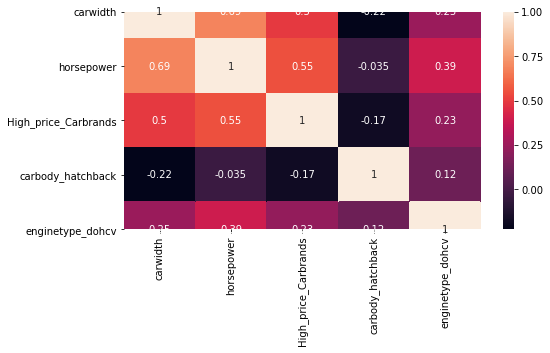

In [46]:
X_train_rfe_new = X_train_rfe_new.drop('cylindernumber_twelve', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (8,4))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* `enginetype_dohcv` based on scatter plot, looks like this variable not that much significant. we can drop this variable to check the effect 

# Model_6:

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     308.0
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           1.04e-67
Time:                        20:24:46   Log-Likelihood:                 181.06
No. Observations:                 143   AIC:                            -352.1
Df Residuals:                     138   BIC:                            -337.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0824 

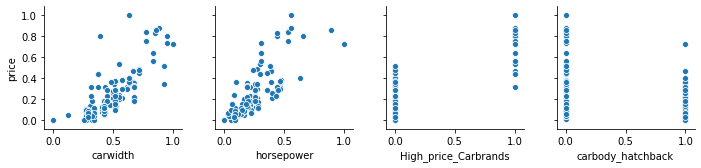

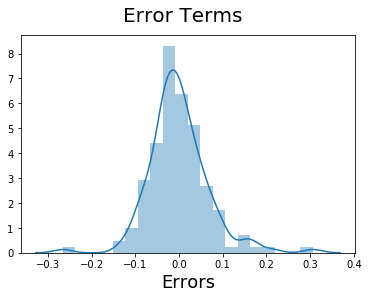

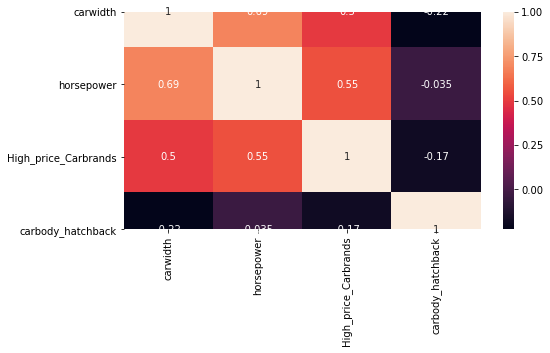

In [47]:
X_train_rfe_new = X_train_rfe_new.drop('enginetype_dohcv', axis= 1)

# adding a constant variable
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

X_train_rfe_new_lm = sm.OLS(y_train, X_train_rfe_new).fit()
print(X_train_rfe_new_lm.summary())

# Calculate VIF 
vif = pd.DataFrame()
X = X_train_rfe_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# correlation plots
X_Vif = X_train_rfe_new.drop(['const'], axis = 1)
df_pairplot = pd.concat([X_Vif,y_train], axis=1)
sns.pairplot(data = df_pairplot, x_vars= list(df_pairplot.columns)[:-1], y_vars = 'price')
plt.show()

# Error term check
y_train_pred = X_train_rfe_new_lm.predict(X_train_rfe_new)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)    

# correlation _ heatmap
plt.figure(figsize = (8,4))
sns.heatmap(X_Vif.corr(), annot = True)
plt.show()

* Looks Model fulfilled the requirements.
    * All available independent variables are significant
    * Error term mean approximately zero
    * No multicollinearity
        
          
  * **List of final variables:**
      * horsepower
      * carwidth
      * High_price_Carbrands
          * `jaguar`
          * `buick`
          * `porsche`
          * `bmw`
      * carbody_hatchback

In [48]:
# apply scaler() to test dataset columns
test_col_list = df_test.columns # list of columns from test dataset
df_test[test_col_list] = scaler.transform(df_test[test_col_list])

In [49]:
# Dividing test dataset into X and Y sets for the prediction
y_test = df_test.pop('price')
X_test = df_test[X_Vif.columns]

In [50]:
# add constant
X_test = sm.add_constant(X_test)
y_pred = X_train_rfe_new_lm.predict(X_test)
y_pred.head()

160    0.093095
186    0.156877
59     0.146618
165    0.156942
140    0.037418
dtype: float64

# Model Evaluation:

Text(0, 0.5, 'Car Price')

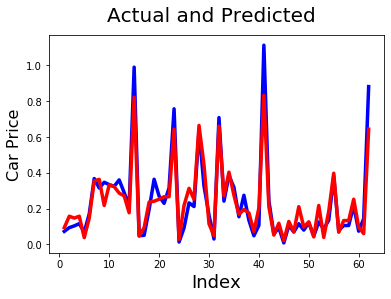

In [51]:
# Actual vs Predicted
c = [i for i in range(1,63,1)]
fig = plt.figure()
# actual y values
plt.plot(c,y_test, color="blue", linewidth=3.5, linestyle="-")     
# predicted y values
plt.plot(c,y_pred, color="red",  linewidth=3.5, linestyle="-")  
fig.suptitle('Actual and Predicted', fontsize=20)              
plt.xlabel('Index', fontsize=18)                              
plt.ylabel('Car Price', fontsize=16)  

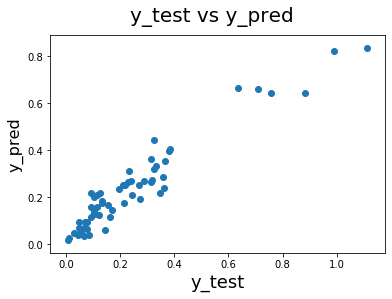

In [52]:
#Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              
plt.xlabel('y_test', fontsize=18)                        
plt.ylabel('y_pred', fontsize=16)
plt.show()

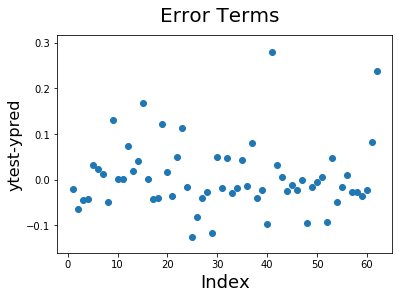

In [53]:
# Error terms pattren check
fig = plt.figure()
c = [i for i in range(1,63,1)]
plt.scatter(c,y_test-y_pred)

fig.suptitle('Error Terms', fontsize=20)              
plt.xlabel('Index', fontsize=18)                      
plt.ylabel('ytest-ypred', fontsize=16)
plt.show()

Text(0, 0.5, 'Index')

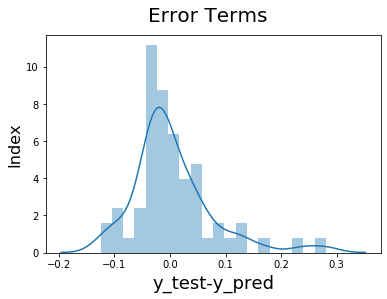

In [54]:
# Plotting the error terms distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=20)
fig.suptitle('Error Terms', fontsize=20)                 
plt.xlabel('y_test-y_pred', fontsize=18)               
plt.ylabel('Index', fontsize=16)          

# Calculate the R-squared score on the test set.

In [55]:
from sklearn.metrics import r2_score,mean_squared_error
print('R^2 Score: ',round(r2_score(y_test, y_pred),3))
print('MSE :',round(mean_squared_error(y_test, y_pred),3))

R^2 Score:  0.899
MSE : 0.005


In [56]:
print(X_train_rfe_new_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     308.0
Date:                Sun, 09 Feb 2020   Prob (F-statistic):           1.04e-67
Time:                        20:24:49   Log-Likelihood:                 181.06
No. Observations:                 143   AIC:                            -352.1
Df Residuals:                     138   BIC:                            -337.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0824 

## Summary:
* R-squared & Adj. R-squared both are pretty close. means all independent variables are significant.
* All independent variables are significant and their p-values are less than 0.05.
* Prob(F-statistics) is approximately Zero. ( 1.04e-67).
* R-square score on the test set is the same as model R-square on a train set. means the model is the best fit for predictions.
* Model can explain about 90% variance